## Based on work from [Chechik et al., 1998.](https://www-mitpressjournals-org.proxy.lib.duke.edu/doi/pdf/10.1162/089976698300017124)

In [1]:
import numpy as np

In [135]:
def hopfield_model_synaptic_deletion(mem, neu, tim, deletion_type, threshold = .5):

    import numpy as np
    import copy
    
    M = mem #number of memories
    N = neu #number of neurons
    timesteps = tim #number of timesteps for the simulation


    #creating patterns
    patterns = np.empty(shape = (M, N))
    for m in range(M):
        patterns[m] = np.random.choice([-1, 1], N)


    #creating the initial connectivity matrix based on a sum of the patterns - THIS SEEMS TO BE THE BOTTLENECK
    connectivity = np.zeros(shape = (N, N))
    for m in range(M):
        connectivity += np.outer(patterns[m], patterns[m].T)
    for i in range(N):
        connectivity[i][i] = 0
    
    Wij = connectivity / np.sqrt(M)
    z = Wij.copy()
    t = threshold
    
    ## min val deletion
    if deletion_type == 'min_val':
        for i in range(len(z)):
            for j in range(len(z)):
                if np.abs(z[i][j]) > t:
                    z[i][j] = z[i][j]
                elif z[i][j] == t:
                    z[i][j] = 0
                else:
                    z[i][j] = 0
    ##compressed deletion
    if deletion_type == 'compressed':
        for i in range(len(z)):
            for j in range(len(z)):
                if np.abs(z[i][j]) <= t:
                    z[i][j] = 0
                elif z[i][j] > t:
                    z[i][j] = z[i][j] - t
                elif z[i][j] < -t:
                    z[i][j] = z[i][j] + t
    ##clipping modification/deletion
    if deletion_type == 'clipping':
        for i in range(len(z)):
            for j in range(len(z)):
                if z[i][j] > t:
                    z[i][j] = 1
                elif z[i][j] < -t:
                    z[i][j] = -1
                else:
                    z[i][j] = 0
    
    #set the connectivity matrix to the modified/deleted synaptic values
    Wij = z.copy()

    #want an initial overlap of 0.8
    X = np.zeros(shape = (timesteps, N))
    X[0] = patterns[0].copy()
    n_change = int(X[0].shape[0] * 0.1)
    X[0][1:n_change] = -X[0][1:n_change]
    
    
    #update the model for every timestep based on its sign
    for t in range(timesteps - 1):
        X[t+1,:] = np.sign(Wij.dot(X[t,:]))

    #create an array to hold the overlap percentages   
    m_overlap = np.empty(shape = (timesteps, M))
    mu = []

    #calculate overlap percentages
    for t in range(timesteps):
        for u in range(M):
            mu = []
            for j in range(N):
                mu = np.append(mu, patterns[u][j] * X[t][j])
            m_overlap[t][u] = ((1/N) * mu.sum())
            
    return(m_overlap.take(0, axis = 1)[1])

In [136]:
import matplotlib.pyplot as plt

In [137]:
%%time

del_levels = np.arange(0, 100, 1)
del_types = ['min_val', 'compressed', 'clipping']
x = np.ones(shape = len(del_levels))
memory = np.ones(shape = len(del_levels)) * 3
i = -1
outputs = []

for del_type in del_types:
    i = -1
    for lvl in del_levels:
        i = i + 1
        while x[i] > .95:
            memory[i] = memory[i] + 1
            x[i] = hopfield_model_synaptic_deletion(mem = int(memory[i]), neu = 100-lvl, tim = 2, deletion_type = del_type, threshold = 1)
    outputs = np.append(outputs, memory)
    print(del_type)

min_val
compressed
clipping
Wall time: 7.48 s


In [138]:
outputs

array([10., 13., 14., 13., 16.,  8., 11.,  9., 12., 11.,  9., 12.,  9.,
        9.,  9., 12., 11.,  8., 11.,  9., 10., 11., 11.,  8., 11.,  9.,
        5., 11.,  6.,  9.,  9.,  6., 11.,  8.,  7.,  9.,  7.,  6., 10.,
        4.,  9.,  9.,  8.,  9.,  8.,  9.,  9.,  8.,  5.,  9.,  8.,  4.,
        6.,  8.,  6.,  6.,  5.,  9.,  8.,  8.,  7.,  7.,  9.,  6.,  6.,
        7.,  8.,  4.,  4.,  9.,  6.,  4.,  6.,  8.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  5.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,  4.,
        4.,  4.,  4.,  4.,  4.,  5.,  4.,  4.,  4., 10., 13., 14., 13.,
       16.,  8., 11.,  9., 12., 11.,  9., 12.,  9.,  9.,  9., 12., 11.,
        8., 11.,  9., 10., 11., 11.,  8., 11.,  9.,  5., 11.,  6.,  9.,
        9.,  6., 11.,  8.,  7.,  9.,  7.,  6., 10.,  4.,  9.,  9.,  8.,
        9.,  8.,  9.,  9.,  8.,  5.,  9.,  8.,  4.,  6.,  8.,  6.,  6.,
        5.,  9.,  8.,  8.,  7.,  7.,  9.,  6.,  6.,  7.,  8.,  4.,  4.,
        9.,  6.,  4.,  6.,  8.,  4.,  4.,  4.,  4.,  4.,  4.,  4

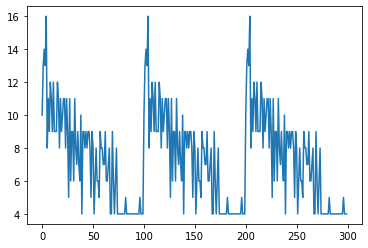

In [139]:
plt.plot(outputs);

In [57]:
min_val = memory.copy()

In [58]:
min_val

array([13.,  6., 11.,  4.,  9.,  9.,  7.,  9.,  9., 10.,  8.,  8., 10.,
        4.,  4.,  6.,  6.,  4.,  6.,  4.])

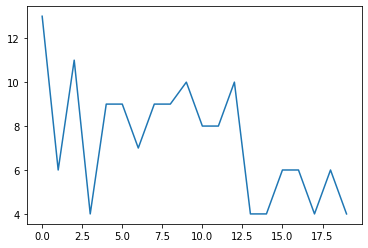

In [59]:
plt.plot(min_val);

In [104]:
np.shape(outputs)

(300,)

In [115]:
binned_counts = []
c = 0
for i in range(300):
    d = c + 5
    x = np.mean(outputs[c:d])
    binned_counts = np.append(binned_counts, x)
    c = d

D:\anaconda\lib\site-packages\numpy\core\fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\anaconda\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


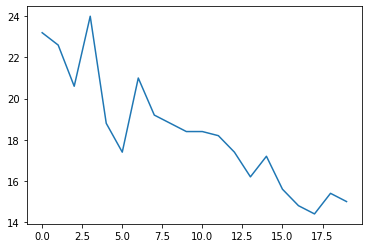

In [118]:
plt.plot(binned_counts[0:20])